### Here's a challenging data modeling problem. It's temperature data collected at 5 minute intervals from Yosemite Village, a small town in Yosemite National Park, California.

### 1. Pull the temperature data set available here. In the The link contains documentation on the headers of each column. 

#### Describe what each variable is in the box below.

WBANNO: The station's unique identifier, known as the Weather-Bureau-Army-Navy (WBAN) number.

UTC_DATE: The observation date in Coordinated Universal Time (UTC), formatted as YYYYMMDD.

UTC_TIME: The observation time in UTC, indicating the end of the 5-minute observation period, formatted as HHmm.

LST_DATE: The observation date in Local Standard Time (LST), formatted as YYYYMMDD.

LST_TIME: The observation time in LST, indicating the end of the 5-minute observation period, formatted as HHmm.

CRX_VN: The version number of the station's datalogger program active during the observation.

LONGITUDE: The station's longitude in decimal degrees, based on the WGS-84 coordinate system.

LATITUDE: The station's latitude in decimal degrees, based on the WGS-84 coordinate system.

AIR_TEMPERATURE: The average air temperature over the 5-minute period, measured in degrees Celsius.

PRECIPITATION: The total precipitation accumulated during the 5-minute period, measured in millimeters.

SOLAR_RADIATION: The average global solar radiation received during the 5-minute period, measured in watts per square meter (W/m²).

SR_FLAG: Quality control flag for the solar radiation measurement.

SURFACE_TEMPERATURE: The average infrared surface temperature over the 5-minute period, measured in degrees Celsius.

ST_TYPE: Indicates the type of surface temperature measurement: 'R' for raw (uncorrected), 'C' for corrected, and 'U' for unknown/missing.

ST_FLAG: Quality control flag for the surface temperature measurement.

RELATIVE_HUMIDITY: The average relative humidity over the 5-minute period, expressed as a percentage.

RH_FLAG: Quality control flag for the relative humidity measurement.

SOIL_MOISTURE_5: The average soil moisture at 5 cm below the surface, expressed as volumetric water content (m³/m³).

SOIL_TEMPERATURE_5: The average soil temperature at 5 cm below the surface, measured in degrees Celsius.

WETNESS: Indicates the presence or absence of moisture due to precipitation, measured in Ohms. High values (≥ 1000) suggest an absence of moisture, while low values (< 1000) indicate moisture presence.

WET_FLAG: Quality control flag for the wetness measurement.

WIND_1_5: The average wind speed at a height of 1.5 meters during the 5-minute period, measured in meters per second (m/s).

WIND_FLAG: Quality control flag for the wind speed measurement.



### 2. In the first code cell below is some python code that fits a straight line to the temperature data. 
Some of the fancier LLM implementations can really help with data analysis. 
If you happen to have access to CodeGPT or similar LLM that can handle .csv uploads, you can run this data through it and try different #descriptivestats analyses on it to get a sense of what's going on. 

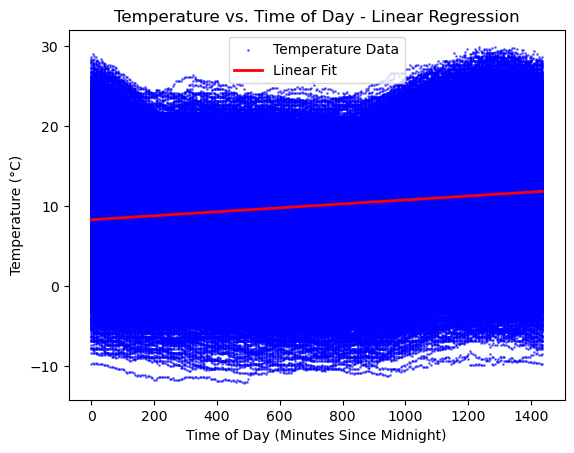

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# Define the directory containing the data files
data_dir = "yosemite-temperatures/yosemite_village/"

# Define the years of interest
years = range(2011, 2017)

# Generate file paths
files = [f"{data_dir}CRNS0101-05-{y}-CA_Yosemite_Village_12_W.txt" for y in years]

# Define which columns to use: 
# Column 1: UTC_DATE (YYYYMMDD)
# Column 2: UTC_TIME (HHmm)
# Column 8: AIR_TEMPERATURE (Celsius)
usecols = [1, 2, 8]

# Load and stack data from all files
data = [np.loadtxt(f, usecols=usecols) for f in files]  # Read data from each file
data = np.vstack(data)  # Stack into a single array

# Convert HHmm time format to minutes since midnight
data[:, 1] = np.floor_divide(data[:, 1], 100) * 60 + np.mod(data[:, 1], 100)

# Filter out invalid temperature values (-1000 is used for missing data)
valid = data[:, 2] > -1000

# Prepare training data (time of day as input, temperature as output)
x_train = data[valid, 1].reshape(-1, 1)  # Reshape for sklearn
y_train = data[valid, 2]

# Fit a linear regression model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Make predictions for the start (00:00) and end of the day (23:55)
x_predict = np.array([[0], [1435]])  # 0 minutes and 1435 minutes (23:55)
y_predict = regr.predict(x_predict)

# Plot results
plt.scatter(x_train, y_train, label="Temperature Data", color="blue", alpha=0.5, s=1)
plt.plot(x_predict, y_predict, label="Linear Fit", color="red", linewidth=2)
plt.xlabel("Time of Day (Minutes Since Midnight)")
plt.ylabel("Temperature (°C)")
plt.legend(loc="best")
plt.title("Temperature vs. Time of Day - Linear Regression")
plt.show()


### 3. Explain why the linear model's performance is so poor. 

Hint: Think about how temperature data changes over time. What are the different effects you might need to model. What shapes would be necessary to model them? 


The red line in the plot is a linear regression fit, which assumes temperature changes at a constant rate over time.

However, temperature Follows a non-linear trend

Within a day, temperature typically follows a sinusoidal pattern. 
It rises in the morning, peaks in the afternoon, and then cools down overnight.

Across months and years, temperature exhibits long-term periodic trends due to seasonal effects.

Also, temperature can spike or drop unexpectedly due to weather events, cloud cover, precipitation, and other short-term influences.

Because temperatures rise and fall cyclically, the linear model’s slope is forced to average out the fluctuations.
As a result, it finds a nearly flat line that fails to capture meaningful structure in the data.


To properly model temperature, we need a non-linear approac. Some examples are periodic basis functions (like Fourier Series / Radial Basis Functions) or time series models.

### 4a. In the second code cell is some python code for fitting a linear parameter model using a radial basis function.

centers.shape (6, 1)
heights.shape (4, 1)
weights.shape (4, 1)
x.shape (4, 6)
Original inputs [[1.32]
 [1.45]
 [1.66]
 [1.88]]
RBF repr [[0.81481026 0.97161077 0.98728157 0.85487502 0.63077882 0.39661073]
 [0.66697681 0.8824969  0.99501248 0.95599748 0.78270454 0.54607443]
 [0.41844911 0.65494763 0.87354119 0.99282586 0.96155838 0.79358073]
 [0.21250282 0.39661073 0.63077882 0.85487502 0.98728157 0.97161077]]
Score on training data =  0.9430228201545772
all_x.shape (1000, 1)
expanded_x.shape (1000, 6)
all_y.shape (1000, 1)


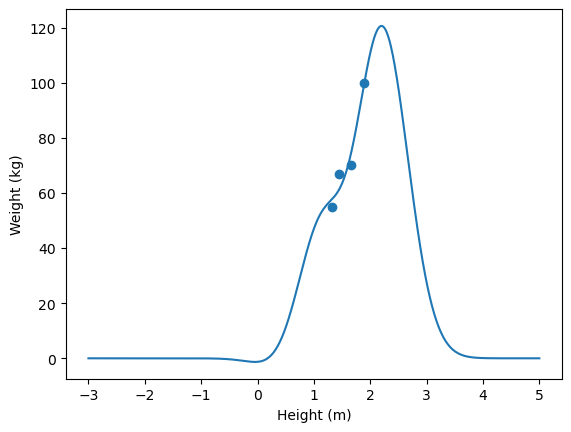

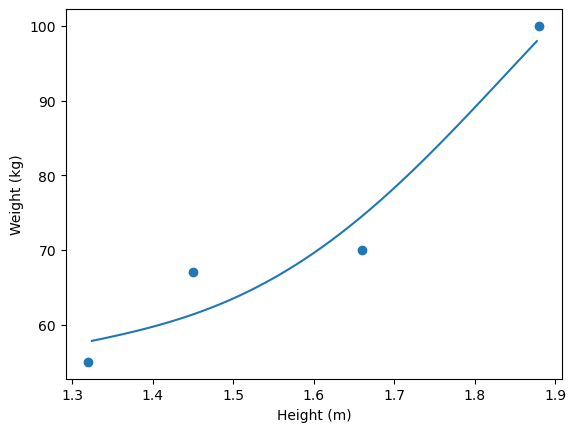

In [6]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

# Try to predict weight as a function of height.
# Physics would suggest that weight is proportional to volume,
# and volume is proportional to height^3.  However we will
# use a linear parameter model with radial basis functions
# to model this nonlinear relationship.

heights = np.asarray([1.32, 1.45, 1.66, 1.88]).reshape(-1, 1)
weights = np.asarray([55, 67, 70, 100]).reshape(-1, 1)
centers = np.asarray([1.0, 1.2, 1.4, 1.6, 1.8, 2.0]).reshape(-1, 1)
print("centers.shape", centers.shape)
print("heights.shape", heights.shape)
print("weights.shape", weights.shape)

# I recommend playing around with these parameters and seeing how well you fit
# the data.  Changing one of the parameters will change the optimal value of
# the other:
sigma = 0.5
alpha = 0.0001

# New representation:
x = rbf_kernel(heights, centers, gamma=1.0 / sigma)
print("x.shape", x.shape)
print("Original inputs", heights)
print("RBF repr", x)

# Now go and fit a linear model between x and height
regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(x, weights)
print("Score on training data = ", regr.score(x, weights))
all_x = np.linspace(-3.0, 5.0, 1000).reshape(-1, 1)

# New representation:
expanded_x = rbf_kernel(all_x, centers, gamma=1.0 / sigma)
all_y = regr.predict(expanded_x)
print("all_x.shape", all_x.shape)
print("expanded_x.shape", expanded_x.shape)
print("all_y.shape", all_y.shape)

# Show that the predictions tend to zero far away from inputs
plt.figure()
plt.plot(all_x, all_y)
plt.scatter(heights, weights)
plt.xlabel("Height (m)")
plt.ylabel("Weight (kg)")


# Zoom in and see how well predictions fit the data
zoom_ind = (all_x > heights.min()) & (all_x < heights.max())
plt.figure()
plt.plot(all_x[zoom_ind], all_y[zoom_ind])
plt.scatter(heights, weights)
plt.xlabel("Height (m)")
plt.ylabel("Weight (kg)")
plt.show()

### 4b. Modification to the above code

- Replace height with time of day (in minutes).
- Replace weight with temperature.
- Adjust centers to be spread throughout the 24-hour day (0 to 1435 minutes).
- Tune sigma and alpha to improve fit.

Score on training data =  -0.4760610405962351


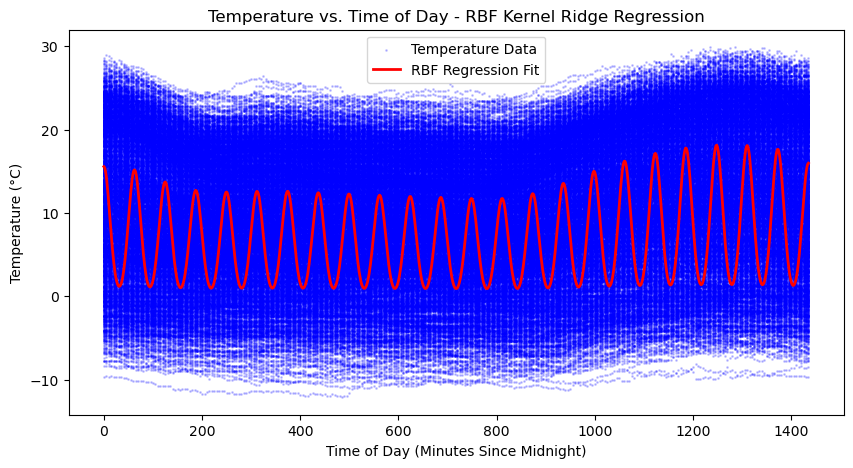

In [7]:
# Time (in minutes since midnight) as input variable
x_train = data[valid, 1].reshape(-1, 1)  # Time in minutes (0 to 1435)
y_train = data[valid, 2]  # Temperature in Celsius

# Define RBF centers (every hour across 24 hours)
centers = np.linspace(0, 1435, 24).reshape(-1, 1)  # One center per hour

# Set hyperparameters (you can adjust these for better performance)
sigma = 300  # Spread of RBF function (tune this for smoothness)
alpha = 0.1  # Ridge regression regularization strength

# Transform input data using RBF Kernel
x_rbf = rbf_kernel(x_train, centers, gamma=1.0 / sigma)

# Fit a Ridge regression model using RBF features
regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(x_rbf, y_train)
print("Score on training data = ", regr.score(x_rbf, y_train))

# Generate test points for full 24-hour range
x_test = np.linspace(0, 1435, 1000).reshape(-1, 1)  # Every minute
x_test_rbf = rbf_kernel(x_test, centers, gamma=1.0 / sigma)
y_test_pred = regr.predict(x_test_rbf)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label="Temperature Data", color="blue", alpha=0.2, s=1)
plt.plot(x_test, y_test_pred, label="RBF Regression Fit", color="red", linewidth=2)
plt.xlabel("Time of Day (Minutes Since Midnight)")
plt.ylabel("Temperature (°C)")
plt.legend(loc="best")
plt.title("Temperature vs. Time of Day - RBF Kernel Ridge Regression")
plt.show()


### 5. In the third code cell, decide on a metric to measure performance for your model record your performance. 

Bring your best model to class, and be prepared to describe how you built this model.

In [9]:
from sklearn.metrics import r2_score

# Predict on training data
y_train_pred = regr.predict(x_rbf)

r2 = r2_score(y_train, y_train_pred)

# Print results
print(f"R² Score: {r2:.4f}")


R² Score: -0.4761


Negative R^2 means our model performs worse than simply predicting the mean temperature.
This suggests severe underfitting, meaning our model is not capturing the underlying temperature patterns.

### Extension

Best R² Score: 0.0445
Optimal Hyperparameters - Sigma: 500, Alpha: 0.01, Centers: 144


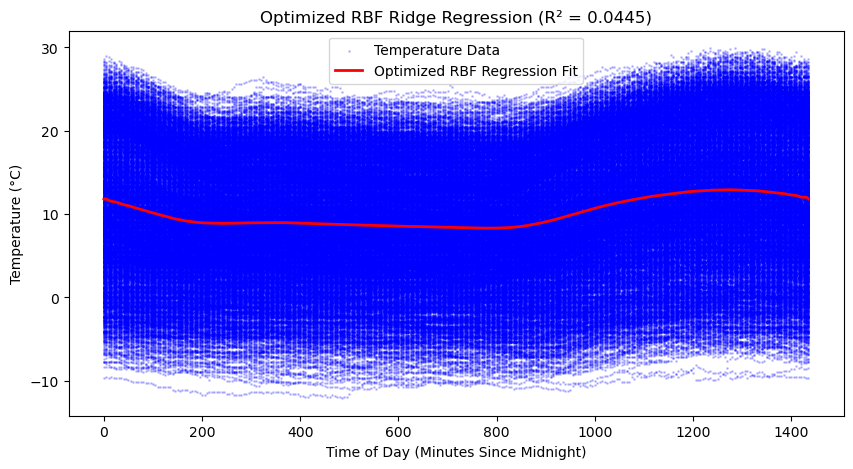

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define hyperparameter search space
sigma_values = [50, 100, 200, 300, 500]  # Smaller values give more localized fits
alpha_values = [0.01, 0.1, 1, 10]  # Smaller values reduce regularization
num_centers = [24, 48, 96, 144]  # Increasing number of centers to capture complexity

best_r2 = -np.inf
best_params = None
best_model = None

for sigma, alpha, n_centers in product(sigma_values, alpha_values, num_centers):
    # Define RBF centers (spread evenly over 24 hours)
    centers = np.linspace(0, 1435, n_centers).reshape(-1, 1)

    # Transform input data using RBF Kernel
    x_rbf = rbf_kernel(x_train, centers, gamma=1.0 / sigma)

    # Fit a Ridge regression model
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(x_rbf, y_train)

    # Predict and evaluate
    y_train_pred = regr.predict(x_rbf)
    r2 = r2_score(y_train, y_train_pred)

    # Track the best performing model
    if r2 > best_r2:
        best_r2 = r2
        best_params = (sigma, alpha, n_centers)
        best_model = regr

print(f"Best R² Score: {best_r2:.4f}")
print(f"Optimal Hyperparameters - Sigma: {best_params[0]}, Alpha: {best_params[1]}, Centers: {best_params[2]}")

# Generate predictions with the best model
x_test = np.linspace(0, 1435, 1000).reshape(-1, 1)
x_test_rbf = rbf_kernel(x_test, np.linspace(0, 1435, best_params[2]).reshape(-1, 1), gamma=1.0 / best_params[0])
y_test_pred = best_model.predict(x_test_rbf)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label="Temperature Data", color="blue", alpha=0.2, s=1)
plt.plot(x_test, y_test_pred, label="Optimized RBF Regression Fit", color="red", linewidth=2)
plt.xlabel("Time of Day (Minutes Since Midnight)")
plt.ylabel("Temperature (°C)")
plt.legend(loc="best")
plt.title(f"Optimized RBF Ridge Regression (R² = {best_r2:.4f})")
plt.show()


#### More refinement

In [11]:
# New hyperparameter search space
sigma_values = [100, 200, 300]  # Try smaller sigma for more localized RBFs
alpha_values = [0.001, 0.01, 0.1]  # Keep alpha small to avoid excessive regularization
num_centers = [144, 300, 500]  # Increase the number of RBF centers

best_r2 = -np.inf
best_params = None
best_model = None

for sigma, alpha, n_centers in product(sigma_values, alpha_values, num_centers):
    centers = np.linspace(0, 1435, n_centers).reshape(-1, 1)  # Spread centers across time

    # Transform input data using RBF Kernel
    x_rbf = rbf_kernel(x_train, centers, gamma=1.0 / sigma)

    # Fit Ridge regression model
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(x_rbf, y_train)

    # Predict and evaluate
    y_train_pred = regr.predict(x_rbf)
    r2 = r2_score(y_train, y_train_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_params = (sigma, alpha, n_centers)
        best_model = regr

print(f"Best R² Score: {best_r2:.4f}")
print(f"Optimal Hyperparameters - Sigma: {best_params[0]}, Alpha: {best_params[1]}, Centers: {best_params[2]}")


Best R² Score: 0.0445
Optimal Hyperparameters - Sigma: 100, Alpha: 0.001, Centers: 500
